# Proyek Klasifikasi Gambar: [Rice Image Dataset]
- **Nama:** Adhim Khairil Anam
- **Email:** mc179d5y0334@student.devacademy.id
- **ID Dicoding:** MC179D5Y0334

## Import Semua Packages/Library yang Digunakan

In [1]:
# Libraries yang digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
import os
import shutil
import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tq

# Libraries untuk pemrosesan gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Libraries untuk pembangunan model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import models, layers, callbacks
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
# Mengabaikan Peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preparation

### Data Loading

In [2]:
from google.colab import files
files.upload()  # Pilih dan upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"adhimkhairilanam","key":"1abbb22fdc9fb564b6f2268d2d3c41d8"}'}

In [3]:
# Setup file kredensial Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download Rice Image Dataset dari Kaggle
!kaggle datasets download -d muratkokludataset/rice-image-dataset

# Unzip dataset ke folder rice_dataset
!unzip -q rice-image-dataset.zip -d rice_dataset

Dataset URL: https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset
License(s): CC0-1.0


In [4]:
# Path ke folder yang berisi folder kelas (varietas beras)
dataset_path = 'rice_dataset/Rice_Image_Dataset'

class_counts = {}
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        class_counts[class_name] = len(os.listdir(class_dir))

# Tampilkan hasil
for class_name, count in class_counts.items():
    print(f"Class: {class_name}, Jumlah Data: {count}")

Class: Karacadag, Jumlah Data: 15000
Class: Arborio, Jumlah Data: 15000
Class: Ipsala, Jumlah Data: 15000
Class: Basmati, Jumlah Data: 15000
Class: Jasmine, Jumlah Data: 15000


Dataset yang saya gunakan berfungsi untuk menghitung jumlah gambar per kelas yaitu :

- Ipsala, Jumlah Data: 15000
- Jasmine, Jumlah Data: 15000
- Basmati, Jumlah Data: 15000
- Arborio, Jumlah Data: 15000
- Karacadag, Jumlah Data: 15000
Secara kesuluran dataset yang saya gunakan sudah terdistribusi dengan rata

### Data Preprocessing

#### Split Dataset

In [5]:
# Path ke folder kelas rice
dataset_path = 'rice_dataset/Rice_Image_Dataset'
base_output = 'rice_dataset_split'

split_ratio = {
    'train': 0.8,
    'val': 0.1,
    'test': 0.1
}

# Buat direktori output untuk train, val, test per kelas
for split in ['train', 'val', 'test']:
    for class_name in os.listdir(dataset_path):
        class_split_path = os.path.join(base_output, split, class_name)
        os.makedirs(class_split_path, exist_ok=True)

# Proses setiap kelas
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        all_images = os.listdir(class_path)
        random.shuffle(all_images)

        total = len(all_images)
        train_end = int(total * split_ratio['train'])
        val_end = train_end + int(total * split_ratio['val'])

        train_imgs = all_images[:train_end]
        val_imgs = all_images[train_end:val_end]
        test_imgs = all_images[val_end:]

        # Copy file ke direktori tujuan
        for img_list, split in zip([train_imgs, val_imgs, test_imgs], ['train', 'val', 'test']):
            for img in img_list:
                src = os.path.join(class_path, img)
                dst = os.path.join(base_output, split, class_name, img)
                shutil.copyfile(src, dst)

print("Dataset berhasil dibagi ke dalam folder: train, val, dan test.")

Dataset berhasil dibagi ke dalam folder: train, val, dan test.


Disini saya melakukan teknik splitting pada dataset dengan komposisi : Training set 80%, Validation set 10%, Test set 10%

In [6]:
# Detail komposisi Splitting Data
base_dir = 'rice_dataset_split'
img_size = (150, 150)
batch_size = 32

#Training set
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'train'),
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

# Validation set
val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'val'),
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

#Test set
test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'test'),
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

Found 60000 files belonging to 6 classes.
Found 7500 files belonging to 6 classes.
Found 7500 files belonging to 6 classes.


Komposisi lebih detail nya yaitu :

Terdapat 60000 foto pada Training set yang termasuk dalam 6 class
dan ada 7.500 foto pada Validation set dan Test set

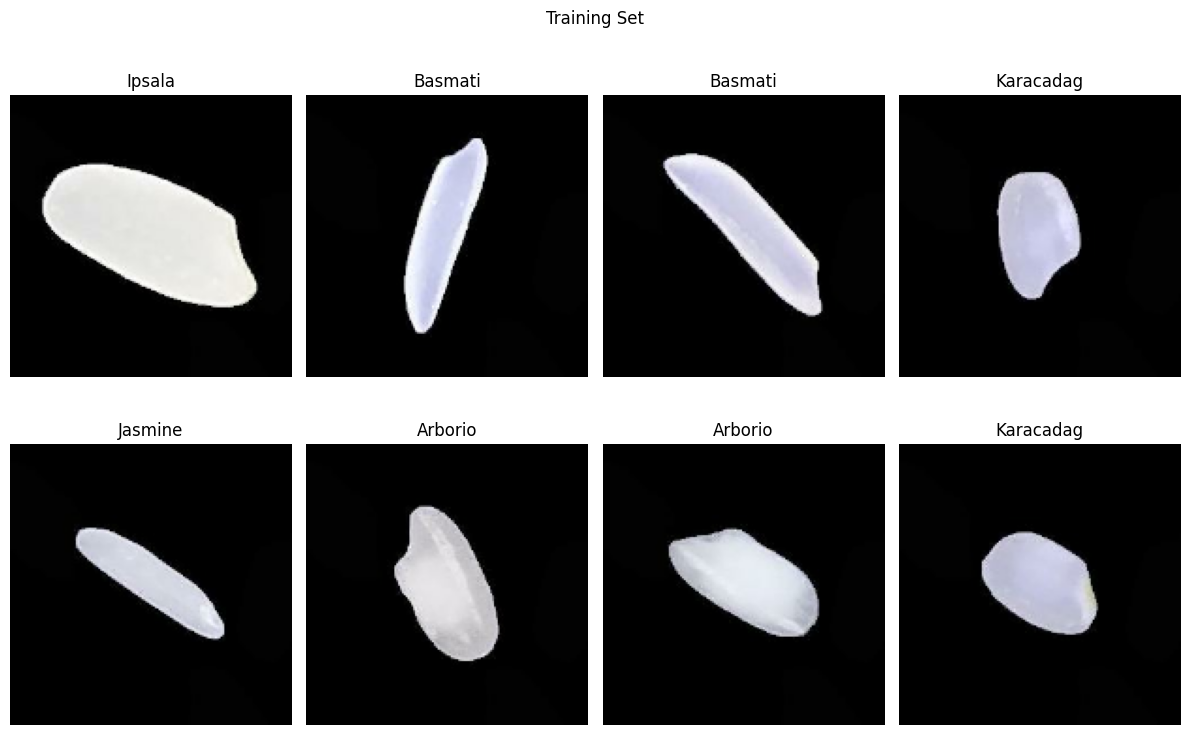

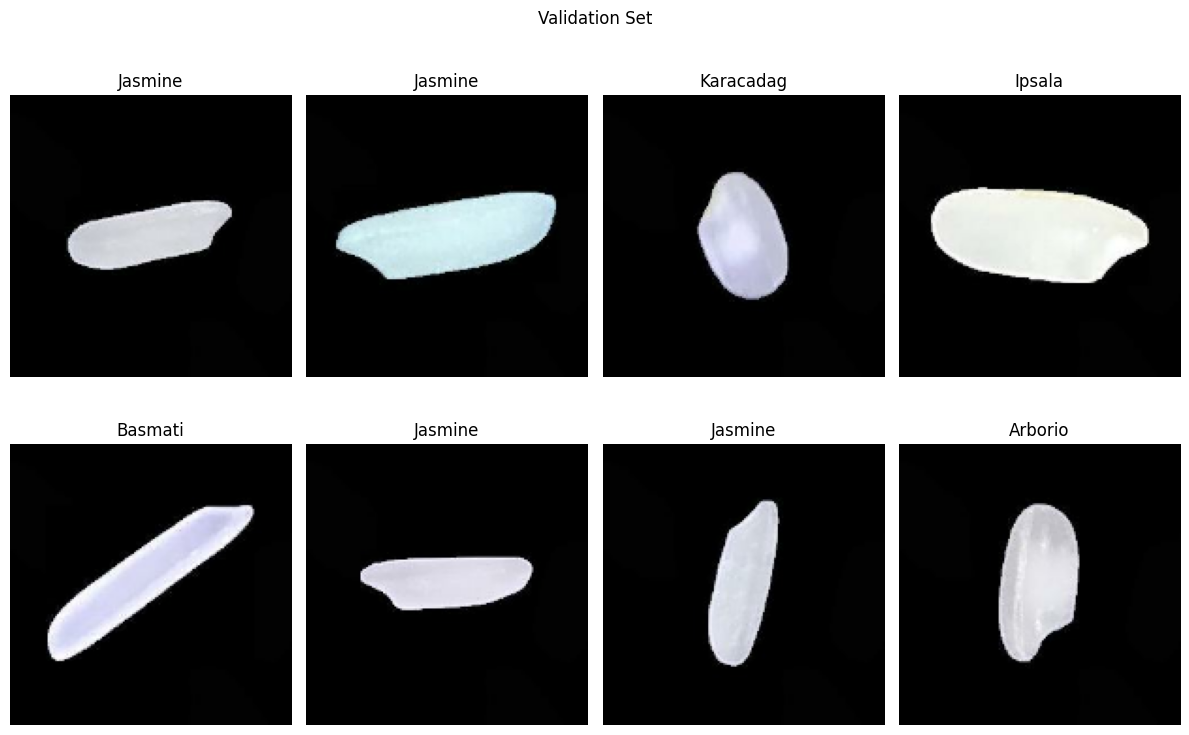

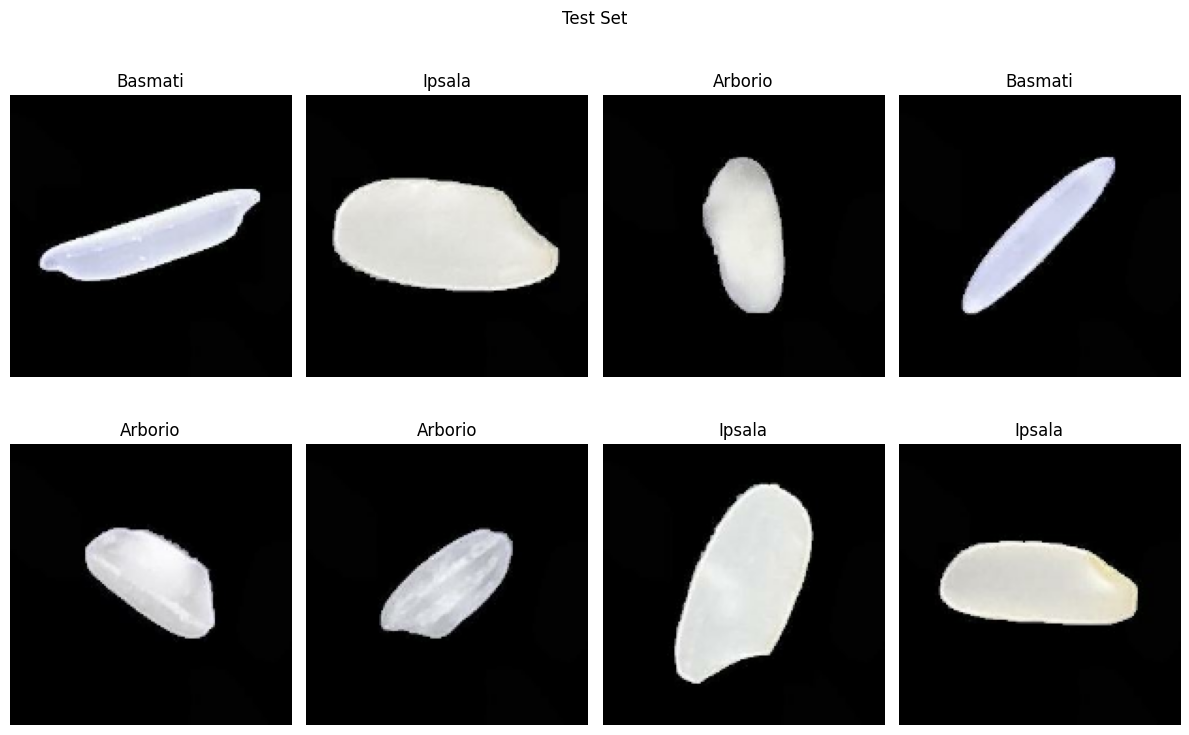

In [7]:
# Visualisasi sample foto pada masing masing split
class_names = train_ds.class_names

def show_images(dataset, title="Split Preview"):
    plt.figure(figsize=(12, 8))
    for images, labels in dataset.take(1):
        for i in range(8):
            ax = plt.subplot(2, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            label_index = tf.argmax(labels[i]).numpy()
            plt.title(class_names[label_index])
            plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_images(train_ds, title="Training Set")
show_images(val_ds, title="Validation Set")
show_images(test_ds, title="Test Set")

## Modelling

In [8]:
# Data augmentasi
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("both"),
    layers.RandomRotation(0.3),
    layers.RandomShear(0.3),
    layers.RandomContrast(0.2),
    layers.RandomZoom(0.1)
])

Saya disi melakukan augmentasi sebagai berikut :

- RandomFlip = membalik gambar (saya menggunakan both yaitu membalik secara vertikal dan horizontal)
- RandomRotation = memutar atau rotasi gambar
- RandomShear = meregangkan atau melenturkan gambar
- RandomContrast = mengubah kontras pada gambar
- RandomZoom = memperbesar atau memperkecil gambar

In [9]:
model = models.Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(150, 150, 3)),

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Dropout(0.3),
    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Menampilkan kelas-kelas yang terdapat pada dataset

In [11]:
pre_trained_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(150, 150, 3))

for layer in pre_trained_model.layers:
    layer.trainable = False

model = Sequential()
model.add(pre_trained_model)

# Tambahan Conv2D dan Pooling
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten(name="flatten"))
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu"))

# Output 6 kelas (bukan 4)
model.add(Dense(6, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


<ipython-input-11-7f1c112ae744>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  pre_trained_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(150, 150, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 5, 5, 32)       │       368,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 2, 2, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,654,246 (10.13 MB)

 Trainable params: 396,262 (1.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Menggunakan transferlearning dari MobileNetV2. Input shape yang digunakan adalah 150x150, layers di freeze agar tidak dilatih kembali, dan menambahkan beberapa layer Conv dan Pooling

Mengcompile model dengan optimizer Adam, loss categorical_crossentropy, dan metrics accuracy

In [12]:
# Callbacks
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, min_delta=0.001, restore_best_weights=True, mode='max', baseline=0.96)

Membuat callbacks yang memonitor val_accuracy dan akan berhenti jika tidak mengalami perubahan epoarch

In [14]:
# Melatih model
num_epochs = 10

H = model.fit(
    train_ds,  # Use train_ds directly
    epochs=num_epochs,
    validation_data=val_ds,  # Use val_ds for validation
    callbacks=[checkpoint, early_stopping],
    verbose=1
)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1337s 709ms/step - accuracy: 0.8753 - loss: 0.3425 - val_accuracy: 0.9712 - val_loss: 0.0905
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1300s 687ms/step - accuracy: 0.9721 - loss: 0.0883 - val_accuracy: 0.9789 - val_loss: 0.0687
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1267s 647ms/step - accuracy: 0.9765 - loss: 0.0725 - val_accuracy: 0.9737 - val_loss: 0.0917
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1190s 629ms/step - accuracy: 0.9814 - loss: 0.0613 - val_accuracy: 0.9832 - val_loss: 0.0534
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1204s 620ms/step - accuracy: 0.9813 - loss: 0.0571 - val_accuracy: 0.9804 - val_loss: 0.0604
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1305s 664ms/step - accuracy: 0.9835 - loss: 0.0507 - val_accuracy: 0.9836 - val_loss: 0.0511
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1261s 653ms/step - accuracy: 0.9855 - loss: 0.0466 - val_accuracy: 0.9847 - val_loss: 0.0481
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1170s 624ms/s

dari 5 epoch kita berhasil mencapai akurasi dan validation akurasi yang sudah kita tentukan yaitu 96% pada epoch. Callbacks sangat berguna untuk efisiensi waktu pada pelatihan model

## Evaluasi dan Visualisasi

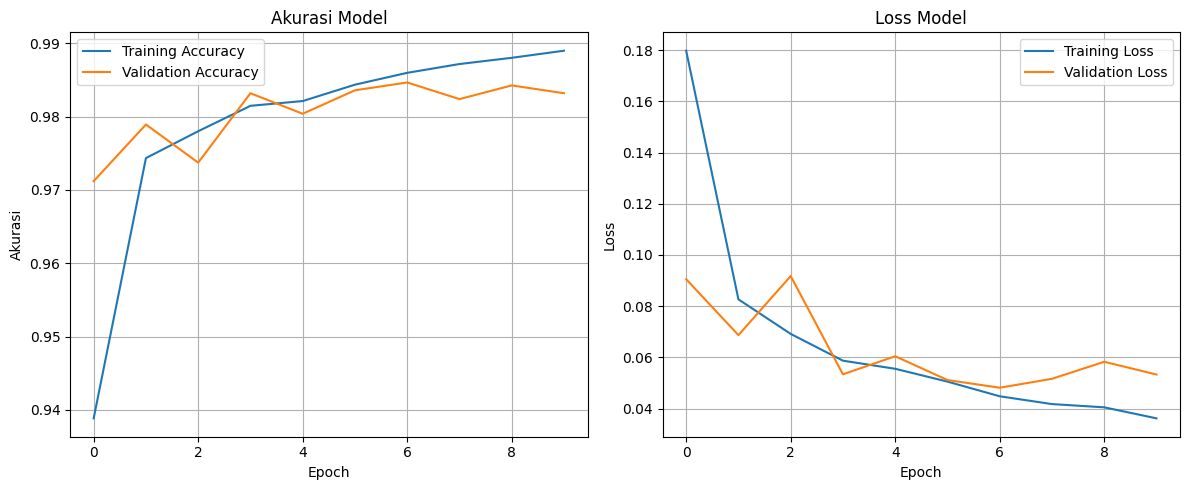

In [15]:
# Plot akurasi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(H.history['accuracy'], label='Training Accuracy')
plt.plot(H.history['val_accuracy'], label='Validation Accuracy')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(H.history['loss'], label='Training Loss')
plt.plot(H.history['val_loss'], label='Validation Loss')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Menampilkan plot akurasi dan plot loss model untuk melihat proses berjalannya pelatihan

In [16]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Akurasi di test set: {test_acc:.2%}")

235/235 ━━━━━━━━━━━━━━━━━━━━ 123s 520ms/step - accuracy: 0.9837 - loss: 0.0575
Akurasi di test set: 98.51%


Disini saya juga menambahkan akurasi pada Test set untuk melihat performa pada data Test. dan saya mendapatkan akurasi sebesar 96%

## Konversi Model

In [17]:
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

TensorFlow version: 2.18.0
Keras version: 3.8.0


In [18]:
# Konversi ke Saved_model
model.export('saved_model')

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  137534686198672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137534686196176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137534686195792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137534686196368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137534686195984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137534686193104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137534686193296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137534686194640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137534686193488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137534686193872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137534686191760

In [19]:
# Konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")
converter.experimental_new_converter = True  # Optional: enable new MLIR-based converter
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,    # Enable TensorFlow Lite ops
    tf.lite.OpsSet.SELECT_TF_OPS       # Enable select TensorFlow ops
]
tflite_model = converter.convert()

# Simpan model.tflite
os.makedirs("tflite", exist_ok=True)
with open("tflite/model.tflite", "wb") as f:
    f.write(tflite_model)

# Simpan label.txt sesuai kelas dalam dataset Rice
labels = ["Arborio", "Basmati", "Ipsala", "Jasmine", "Karacadag", "Baldo"]
with open("tflite/label.txt", "w") as f:
    for label in labels:
        f.write(label + "\n")

In [ ]:
# Install TensorFlow.js converter
!pip install tensorflowjs

# Import library tensorflowjs
import tensorflowjs as tfjs

# Buat direktori untuk menyimpan model TFJS
!mkdir -p tfjs_model

# Simpan model ke format TFJS
tfjs.converters.save_keras_model(model, 'tfjs_model')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


failed to lookup keras version from the file,
    this is likely a weight only file


In [21]:
# Zip semua model yang disimpan
!zip -r model_artifacts.zip saved_model tfjs_model tflite
# Download hasil zip
files.download("model_artifacts.zip")

  adding: saved_model/ (stored 0%)
  adding: saved_model/assets/ (stored 0%)
  adding: saved_model/fingerprint.pb (stored 0%)
  adding: saved_model/saved_model.pb (deflated 90%)
  adding: saved_model/variables/ (stored 0%)
  adding: saved_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: saved_model/variables/variables.index (deflated 78%)
  adding: tfjs_model/ (stored 0%)
  adding: tfjs_model/group1-shard2of3.bin (deflated 7%)
  adding: tfjs_model/group1-shard1of3.bin (deflated 7%)
  adding: tfjs_model/group1-shard3of3.bin (deflated 7%)
  adding: tfjs_model/model.json (deflated 97%)
  adding: tflite/ (stored 0%)
  adding: tflite/label.txt (deflated 2%)
  adding: tflite/model.tflite (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Berhasil menyimpan model ke dalam folder

- saved_model
- tfjs_model
- tflite

In [22]:
import pkg_resources

# Ambil semua package yang terinstall beserta versinya
packages = pkg_resources.working_set
requirements = sorted(["{}=={}".format(pkg.project_name, pkg.version) for pkg in packages])

# Tulis ke requirements.txt
with open("requirements.txt", "w") as f:
    f.write("\n".join(requirements))

print("requirements.txt berhasil dibuat.")

requirements.txt berhasil dibuat.


## Inference (Optional)

In [23]:
# Load model dari folder SavedModel
model = tf.saved_model.load("saved_model")

In [24]:
# Upload file gambar (misal .jpg)
from google.colab import files
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

Saving basmati (10).jpg to basmati (10).jpg


Output prediksi: {'output_0': <tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[6.6404005e-05, 5.6270498e-08, 9.9993014e-01, 3.3726917e-06,
        3.0365097e-08, 7.2280926e-14]], dtype=float32)>}
Prediksi kelas: 2
Prediksi label: Ipsala


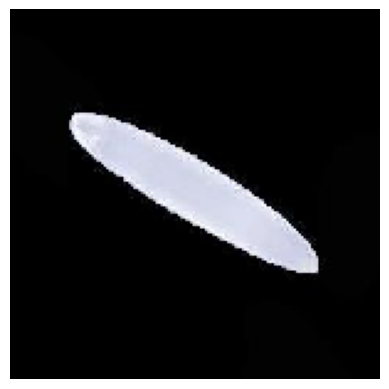

In [25]:
# Contoh path gambar dari kelas Basmati di folder test
img_path = list(uploaded.keys())[0] # Use the uploaded file's name, this is retrieved from files.upload() output.
img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # Normalisasi
img_array = np.expand_dims(img_array, axis=0)  # Tambah batch dimensi

# Prediksi menggunakan SavedModel
input_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
infer = model.signatures["serving_default"]
input_name = list(infer.structured_input_signature[1].keys())[0]
predictions = infer(**{input_name: input_tensor})

# Hasil prediksi (probabilitas per kelas)
print("Output prediksi:", predictions)

# Ambil kelas dengan skor tertinggi
predicted_index = np.argmax(list(predictions.values())[0])
print("Prediksi kelas:", predicted_index)

# Label sesuai dengan Rice Image Dataset
labels = ["Arborio", "Basmati", "Ipsala", "Jasmine", "Karacadag", "Baldo"]
print("Prediksi label:", labels[predicted_index])

# Tampilkan gambar
plt.imshow(img)
plt.axis("off")
plt.show()

Prediksi berdasarkan unggahan foto sudah berhasil dan dapat memprediksi sesuai dengan kelas yang ada pada foto